# Part 1

num_train_batches = 106
num_val_batches   = 12
num_test_batches  = 40
Epoch [1/10] Train Loss: 1.8848  Train Acc: 0.5291 Val Loss: 1.3565  Val Acc: 0.6432
Epoch [2/10] Train Loss: 1.0728  Train Acc: 0.6629 Val Loss: 0.9072  Val Acc: 0.6907
Epoch [3/10] Train Loss: 0.8327  Train Acc: 0.7059 Val Loss: 0.7797  Val Acc: 0.7257
Epoch [4/10] Train Loss: 0.7383  Train Acc: 0.7430 Val Loss: 0.7059  Val Acc: 0.7565
Epoch [5/10] Train Loss: 0.6745  Train Acc: 0.7699 Val Loss: 0.6532  Val Acc: 0.7763
Epoch [6/10] Train Loss: 0.6261  Train Acc: 0.7870 Val Loss: 0.6083  Val Acc: 0.7972
Epoch [7/10] Train Loss: 0.5891  Train Acc: 0.7987 Val Loss: 0.5832  Val Acc: 0.8020
Epoch [8/10] Train Loss: 0.5627  Train Acc: 0.8088 Val Loss: 0.5601  Val Acc: 0.8107
Epoch [9/10] Train Loss: 0.5402  Train Acc: 0.8152 Val Loss: 0.5493  Val Acc: 0.8117
Epoch [10/10] Train Loss: 0.5234  Train Acc: 0.8190 Val Loss: 0.5258  Val Acc: 0.8182


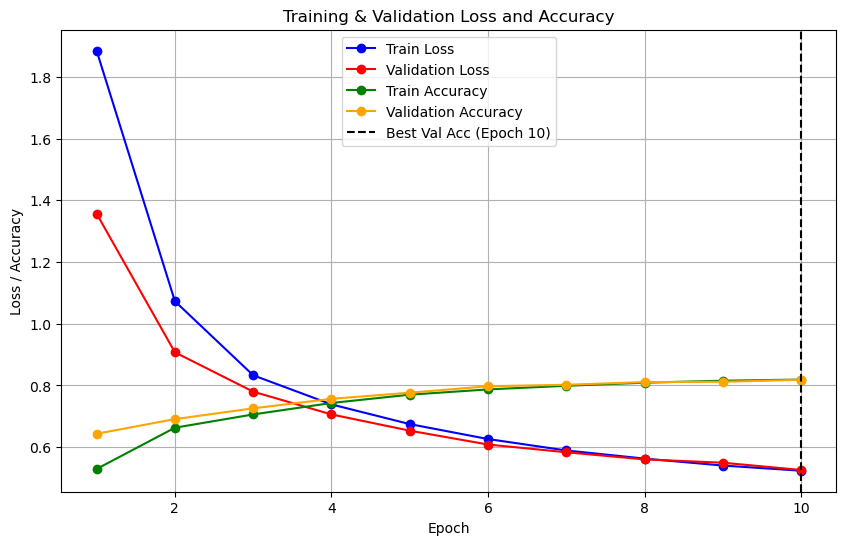

Best Validation Accuracy: 0.8182 at Epoch 10
Final Test Accuracy: 0.8090


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1) Data Loading
train_dataset = torchvision.datasets.FashionMNIST(
    'data/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_dataset = torchvision.datasets.FashionMNIST(
    'data/', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

# Create a validation set (10% of the training set)
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

train_split = Subset(train_dataset, train_indices)
val_split   = Subset(train_dataset, val_indices)

# Batch sizes
train_batch_size = 512
test_batch_size  = 256

train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches   = DataLoader(val_split,   batch_size=train_batch_size, shuffle=True)
test_batches  = DataLoader(test_dataset,batch_size=test_batch_size,  shuffle=True)

num_train_batches = len(train_batches)
num_val_batches   = len(val_batches)
num_test_batches  = len(test_batches)

print("num_train_batches =", num_train_batches)
print("num_val_batches   =", num_val_batches)
print("num_test_batches  =", num_test_batches)

# 2) Define a Fully Connected Network (FCN)
class FCN(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[256, 128], output_dim=10):
        super(FCN, self).__init__()
        layers = []
        all_dims = [input_dim] + hidden_dims + [output_dim]
        
        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
            if i < len(all_dims) - 2:  # Apply ReLU to hidden layers
                layers.append(nn.ReLU())

        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten from (batch_size, 1, 28, 28) to (batch_size, 784)
        return self.network(x)

# 3) Instantiate Model & Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(input_dim=784, hidden_dims=[256,128], output_dim=10).to(device)

learning_rate = 0.01
num_epochs    = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # Using SGD (No Momentum)

# 4) Training & Validation Loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_batches:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Compute Training Metrics
    train_loss = running_loss / num_train_batches
    train_losses.append(train_loss)
    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_correct, val_total, val_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_batches:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_running_loss / num_val_batches
    val_losses.append(val_loss)
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    # Track the Best Validation Accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1  # Convert index to epoch number

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}")

# 5) Combined Plot: Loss & Accuracy with Best Validation Mark
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(10,6))

# Loss Curves
plt.plot(epochs_range, train_losses, 'o-', label='Train Loss', color='blue')
plt.plot(epochs_range, val_losses, 'o-', label='Validation Loss', color='red')

# Accuracy Curves
plt.plot(epochs_range, train_accuracies, 'o-', label='Train Accuracy', color='green')
plt.plot(epochs_range, val_accuracies, 'o-', label='Validation Accuracy', color='orange')

# Mark Best Validation Accuracy
plt.axvline(x=best_epoch, color='black', linestyle='--', label=f'Best Val Acc (Epoch {best_epoch})')

plt.title('Training & Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# 6) Final Testing
model.eval()
test_correct = 0
test_total   = 0
with torch.no_grad():
    for images, labels in test_batches:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total   += labels.size(0)

test_acc = test_correct / test_total

# Print Best Validation Accuracy & Final Test Accuracy
print(f"Best Validation Accuracy: {best_val_acc:.4f} at Epoch {best_epoch}")
print(f"Final Test Accuracy: {test_acc:.4f}")

# Part 2

num_train_batches = 422
num_val_batches   = 47
num_test_batches  = 40
Epoch [1/10] Train Loss: 0.6212  Train Acc: 0.7836 Val Loss: 0.4318  Val Acc: 0.8472
Epoch [2/10] Train Loss: 0.3949  Train Acc: 0.8576 Val Loss: 0.3772  Val Acc: 0.8610
Epoch [3/10] Train Loss: 0.3493  Train Acc: 0.8718 Val Loss: 0.3677  Val Acc: 0.8625
Epoch [4/10] Train Loss: 0.3230  Train Acc: 0.8806 Val Loss: 0.3397  Val Acc: 0.8762
Epoch [5/10] Train Loss: 0.3015  Train Acc: 0.8893 Val Loss: 0.3436  Val Acc: 0.8720
Epoch [6/10] Train Loss: 0.2858  Train Acc: 0.8939 Val Loss: 0.3224  Val Acc: 0.8763
Epoch [7/10] Train Loss: 0.2729  Train Acc: 0.8977 Val Loss: 0.3147  Val Acc: 0.8857
Epoch [8/10] Train Loss: 0.2586  Train Acc: 0.9025 Val Loss: 0.2985  Val Acc: 0.8883
Epoch [9/10] Train Loss: 0.2472  Train Acc: 0.9080 Val Loss: 0.3193  Val Acc: 0.8828
Epoch [10/10] Train Loss: 0.2355  Train Acc: 0.9122 Val Loss: 0.3061  Val Acc: 0.8857


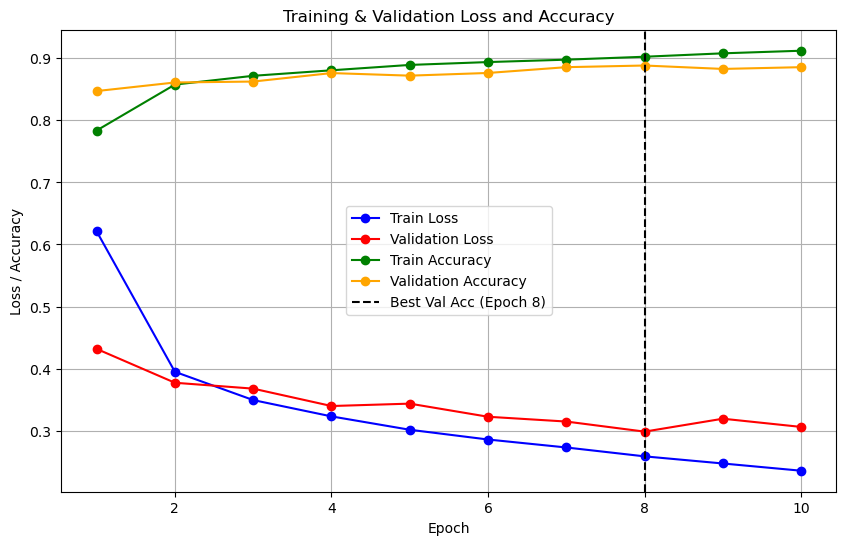

Best Validation Accuracy: 0.8883 at Epoch 8
Final Test Accuracy: 0.8821


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


# 1) Data Loading
train_dataset = torchvision.datasets.FashionMNIST(
    'data/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_dataset = torchvision.datasets.FashionMNIST(
    'data/', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

# Create a validation set (10% of the training set)
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

train_split = Subset(train_dataset, train_indices)
val_split   = Subset(train_dataset, val_indices)

train_batch_size = 128
test_batch_size  = 256

train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches   = DataLoader(val_split,   batch_size=train_batch_size, shuffle=True)
test_batches  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

num_train_batches = len(train_batches)
num_val_batches   = len(val_batches)
num_test_batches  = len(test_batches)

print("num_train_batches =", num_train_batches)
print("num_val_batches   =", num_val_batches)
print("num_test_batches  =", num_test_batches)

# 2) Define a Fully Connected Network (FCN)
class FCN(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[256, 128], output_dim=10):
        super(FCN, self).__init__()
        layers = []
        all_dims = [input_dim] + hidden_dims + [output_dim]
        
        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
            if i < len(all_dims) - 2:  # Apply ReLU to hidden layers
                layers.append(nn.ReLU())

        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten from (batch_size, 1, 28, 28) to (batch_size, 784)
        return self.network(x)

# 3) Instantiate Model & Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(input_dim=784, hidden_dims=[256,128], output_dim=10).to(device)

learning_rate = 0.01
num_epochs    = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# 4) Training & Validation Loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_batches:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Compute Training Metrics
    train_loss = running_loss / num_train_batches
    train_losses.append(train_loss)
    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_correct, val_total, val_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_batches:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_running_loss / num_val_batches
    val_losses.append(val_loss)
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    # Track the Best Validation Accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1  # Convert index to epoch number

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}")

# 5) Combined Plot: Loss & Accuracy with Best Validation Mark
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(10,6))

# Loss Curves
plt.plot(epochs_range, train_losses, 'o-', label='Train Loss', color='blue')
plt.plot(epochs_range, val_losses, 'o-', label='Validation Loss', color='red')

# Accuracy Curves
plt.plot(epochs_range, train_accuracies, 'o-', label='Train Accuracy', color='green')
plt.plot(epochs_range, val_accuracies, 'o-', label='Validation Accuracy', color='orange')

# Mark Best Validation Accuracy
plt.axvline(x=best_epoch, color='black', linestyle='--', label=f'Best Val Acc (Epoch {best_epoch})')

plt.title('Training & Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# 6) Final Testing
model.eval()
test_correct = 0
test_total   = 0
with torch.no_grad():
    for images, labels in test_batches:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total   += labels.size(0)

test_acc = test_correct / test_total

# Print Best Validation Accuracy & Final Test Accuracy
print(f"Best Validation Accuracy: {best_val_acc:.4f} at Epoch {best_epoch}")
print(f"Final Test Accuracy: {test_acc:.4f}")

# Part 3a


Testing SGD with LR=0.0001
[SGD, LR=0.0001] Epoch [1/20] Train Loss: 2.1328, Val Loss: 1.9392, Train Acc: 0.3719, Val Acc: 0.5500
[SGD, LR=0.0001] Epoch [2/20] Train Loss: 1.7082, Val Loss: 1.4837, Train Acc: 0.5822, Val Acc: 0.6045
[SGD, LR=0.0001] Epoch [3/20] Train Loss: 1.3095, Val Loss: 1.1777, Train Acc: 0.6321, Val Acc: 0.6377
[SGD, LR=0.0001] Epoch [4/20] Train Loss: 1.0832, Val Loss: 1.0175, Train Acc: 0.6579, Val Acc: 0.6610
[SGD, LR=0.0001] Epoch [5/20] Train Loss: 0.9604, Val Loss: 0.9238, Train Acc: 0.6776, Val Acc: 0.6823
[SGD, LR=0.0001] Epoch [6/20] Train Loss: 0.8836, Val Loss: 0.8604, Train Acc: 0.6949, Val Acc: 0.7003
[SGD, LR=0.0001] Epoch [7/20] Train Loss: 0.8291, Val Loss: 0.8127, Train Acc: 0.7116, Val Acc: 0.7168
[SGD, LR=0.0001] Epoch [8/20] Train Loss: 0.7866, Val Loss: 0.7743, Train Acc: 0.7269, Val Acc: 0.7363
[SGD, LR=0.0001] Epoch [9/20] Train Loss: 0.7513, Val Loss: 0.7415, Train Acc: 0.7399, Val Acc: 0.7493
[SGD, LR=0.0001] Epoch [10/20] Train Loss: 0.

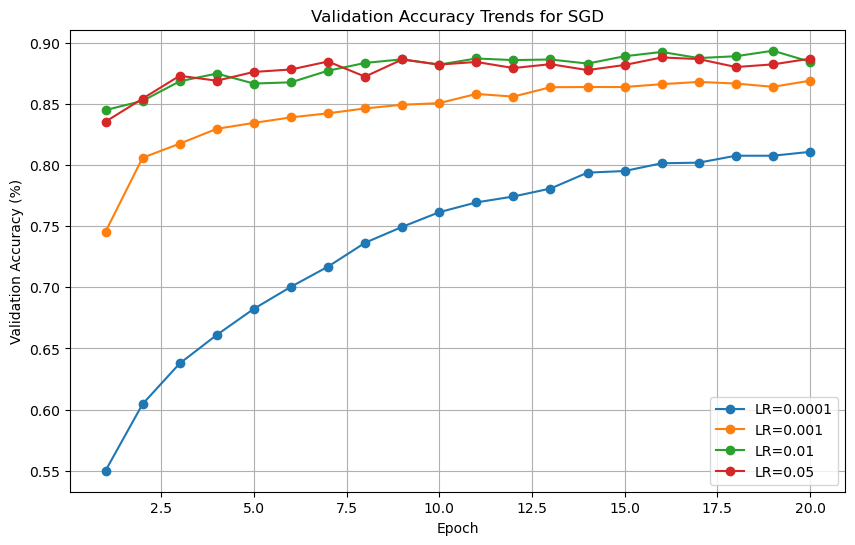

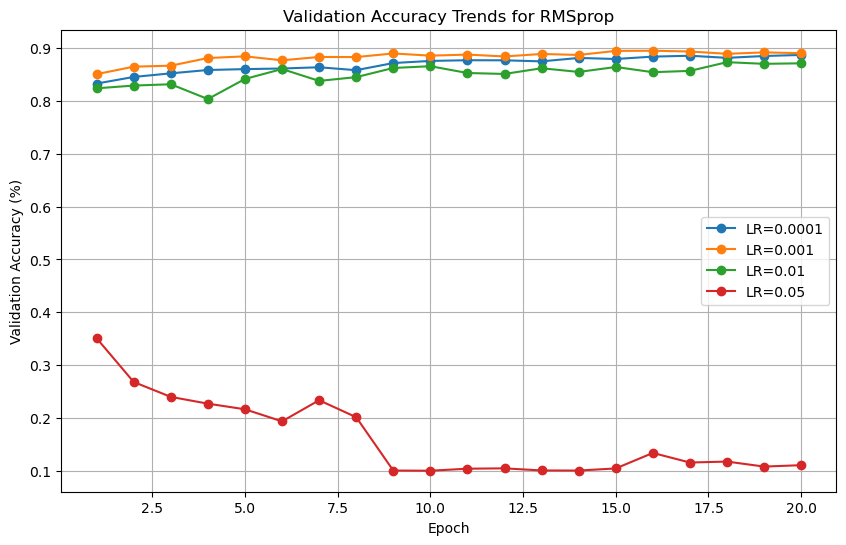

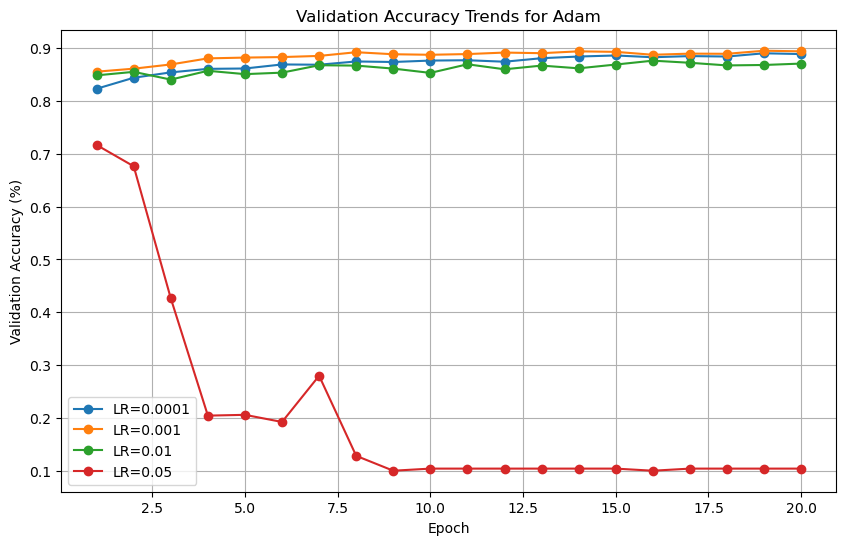

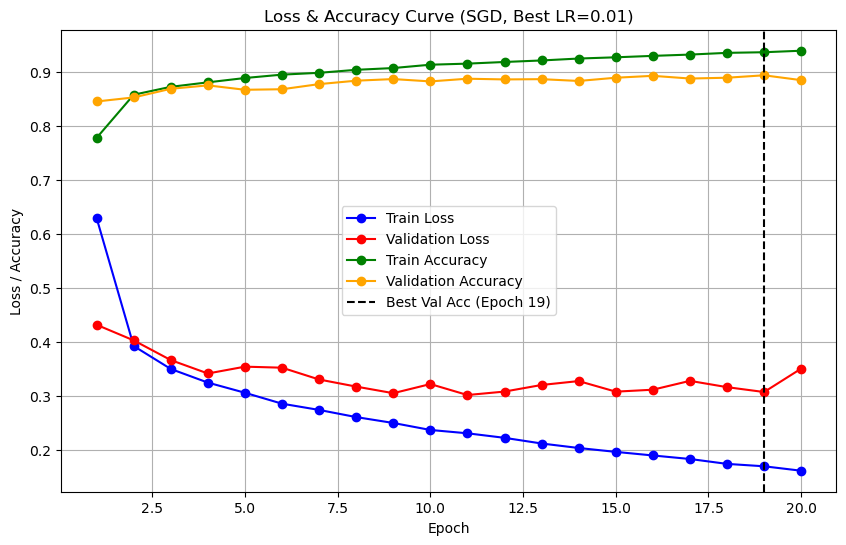

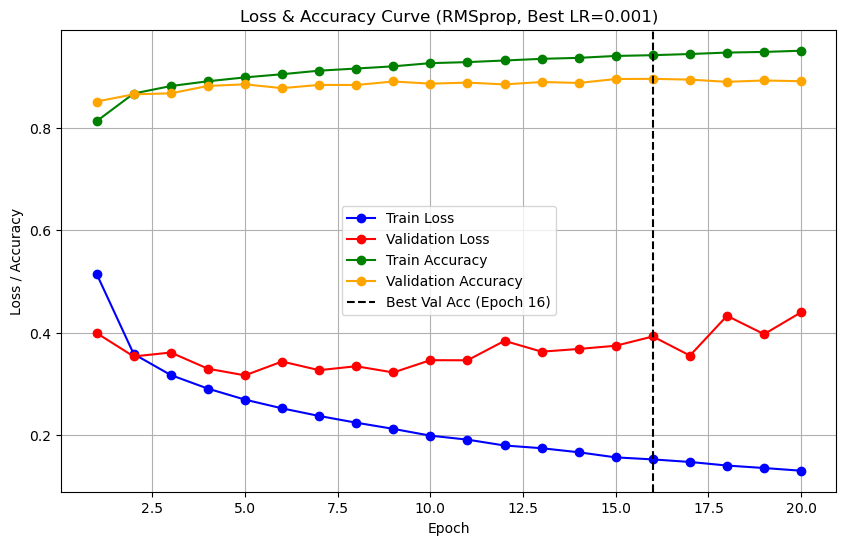

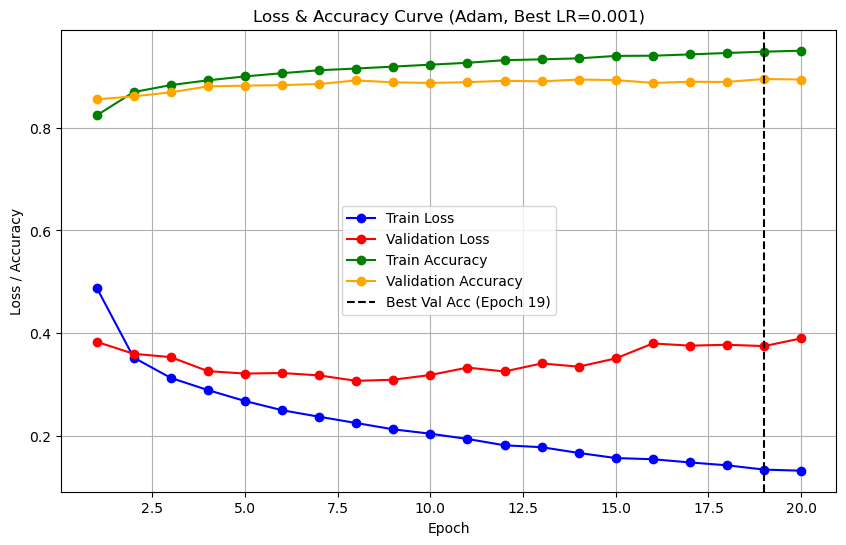


Summary of Best Validation & Test Accuracies:
SGD      | Best LR: 0.0100 | Best Val Acc: 0.8933 | Test Acc: 0.8757
RMSprop  | Best LR: 0.0010 | Best Val Acc: 0.8953 | Test Acc: 0.8833
Adam     | Best LR: 0.0010 | Best Val Acc: 0.8953 | Test Acc: 0.8900


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1) Fully Connected Network (FCN)
class FCN(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[256, 128], output_dim=10):
        super(FCN, self).__init__()
        layers = []
        all_dims = [input_dim] + hidden_dims + [output_dim]

        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
            if i < len(all_dims) - 2:
                layers.append(nn.ReLU())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)

# 2) Training & Evaluation Function
def train_and_evaluate(optimizer_class, lr, num_epochs=20):
    model = FCN(input_dim=784, hidden_dims=[256, 128], output_dim=10).to(device)

    if optimizer_class == optim.SGD:
        optimizer = optimizer_class(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_batches:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / num_train_batches
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_batches:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / num_val_batches
        val_losses.append(val_loss)
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1  

        print(f"[{optimizer_class.__name__}, LR={lr}] Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_acc:.4f}")

    # Final test accuracy
    test_correct, test_total = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_batches:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total

    return train_losses, val_losses, train_accuracies, val_accuracies, best_epoch, best_val_acc, test_acc

# 3) Define a Common Learning Rate Grid for All Optimizers
common_lr_grid = [0.0001, 0.001, 0.01, 0.05]

best_lrs = {}
final_results = {}

# 4) Train and Evaluate Each Optimizer Using the Same Learning Rate Grid
optimizer_results = {opt_name: {} for opt_name in ["SGD", "RMSprop", "Adam"]}

for opt_name in optimizer_results:
    optimizer_class = getattr(optim, opt_name)

    for lr in common_lr_grid:
        print(f"\nTesting {opt_name} with LR={lr}")
        train_losses, val_losses, train_accuracies, val_accuracies, best_epoch, best_val_acc, test_acc = train_and_evaluate(optimizer_class, lr)
        
        optimizer_results[opt_name][lr] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "train_accuracies": train_accuracies,
            "val_accuracies": val_accuracies,
            "best_epoch": best_epoch,
            "best_val_acc": best_val_acc,
            "test_acc": test_acc
        }

    # Select best learning rate for each optimizer
    best_lr = max(optimizer_results[opt_name], key=lambda lr: optimizer_results[opt_name][lr]["best_val_acc"])
    best_lrs[opt_name] = best_lr
    final_results[opt_name] = optimizer_results[opt_name][best_lr]

# 5) Generate 3 Comparison Plots for Different LRs Per Optimizer
for opt_name, results in optimizer_results.items():
    plt.figure(figsize=(10, 6))
    
    for lr in common_lr_grid:
        plt.plot(range(1, 21), results[lr]["val_accuracies"], marker='o', linestyle='-', label=f"LR={lr}")
    
    plt.title(f"Validation Accuracy Trends for {opt_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 6) Generate 3 Individual Plots for Each Optimizer with Best LR
for opt_name, results in final_results.items():
    epochs_range = range(1, 21)

    plt.figure(figsize=(10, 6))

    # Plot Losses
    plt.plot(epochs_range, results["train_losses"], 'o-', label='Train Loss', color='blue')
    plt.plot(epochs_range, results["val_losses"], 'o-', label='Validation Loss', color='red')

    # Plot Accuracies
    plt.plot(epochs_range, results["train_accuracies"], 'o-', label='Train Accuracy', color='green')
    plt.plot(epochs_range, results["val_accuracies"], 'o-', label='Validation Accuracy', color='orange')

    # Mark Best Validation Accuracy Epoch
    plt.axvline(x=results["best_epoch"], color='black', linestyle='--', label=f'Best Val Acc (Epoch {results["best_epoch"]})')

    plt.title(f'Loss & Accuracy Curve ({opt_name}, Best LR={best_lrs[opt_name]})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# 7) Summary of Best Validation & Test Accuracies
print("\nSummary of Best Validation & Test Accuracies:")
for opt_name, best_lr in best_lrs.items():
    print(f"{opt_name:<8} | Best LR: {best_lr:.4f} | Best Val Acc: {final_results[opt_name]['best_val_acc']:.4f} | Test Acc: {final_results[opt_name]['test_acc']:.4f}")

# Part 3b

No Dropout, SGD, LR=0.01, epochs=10
[SGD, LR=0.01, Dropout=0.0] Epoch [1/10] Train Loss: 0.6117, Val Loss: 0.4375, Train Acc: 0.7831, Val Acc: 0.8462
[SGD, LR=0.01, Dropout=0.0] Epoch [2/10] Train Loss: 0.3940, Val Loss: 0.3876, Train Acc: 0.8570, Val Acc: 0.8595
[SGD, LR=0.01, Dropout=0.0] Epoch [3/10] Train Loss: 0.3503, Val Loss: 0.3545, Train Acc: 0.8722, Val Acc: 0.8713
[SGD, LR=0.01, Dropout=0.0] Epoch [4/10] Train Loss: 0.3263, Val Loss: 0.3583, Train Acc: 0.8809, Val Acc: 0.8667
[SGD, LR=0.01, Dropout=0.0] Epoch [5/10] Train Loss: 0.3023, Val Loss: 0.3371, Train Acc: 0.8895, Val Acc: 0.8767
[SGD, LR=0.01, Dropout=0.0] Epoch [6/10] Train Loss: 0.2867, Val Loss: 0.3358, Train Acc: 0.8956, Val Acc: 0.8773
[SGD, LR=0.01, Dropout=0.0] Epoch [7/10] Train Loss: 0.2701, Val Loss: 0.3363, Train Acc: 0.8994, Val Acc: 0.8763
[SGD, LR=0.01, Dropout=0.0] Epoch [8/10] Train Loss: 0.2569, Val Loss: 0.3151, Train Acc: 0.9050, Val Acc: 0.8835
[SGD, LR=0.01, Dropout=0.0] Epoch [9/10] Train Loss:

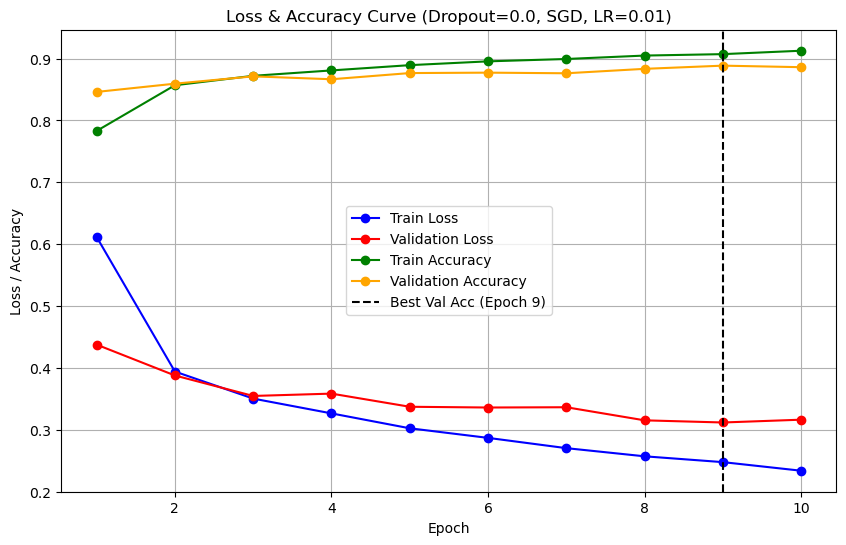

Final Test Accuracy (SGD, LR=0.01, Dropout=0.0): 0.8834

With Dropout=0.3, SGD, LR=0.01, epochs=10
[SGD, LR=0.01, Dropout=0.3] Epoch [1/10] Train Loss: 0.7061, Val Loss: 0.4467, Train Acc: 0.7451, Val Acc: 0.8377
[SGD, LR=0.01, Dropout=0.3] Epoch [2/10] Train Loss: 0.4517, Val Loss: 0.3966, Train Acc: 0.8361, Val Acc: 0.8575
[SGD, LR=0.01, Dropout=0.3] Epoch [3/10] Train Loss: 0.4089, Val Loss: 0.3672, Train Acc: 0.8516, Val Acc: 0.8670
[SGD, LR=0.01, Dropout=0.3] Epoch [4/10] Train Loss: 0.3836, Val Loss: 0.3483, Train Acc: 0.8627, Val Acc: 0.8702
[SGD, LR=0.01, Dropout=0.3] Epoch [5/10] Train Loss: 0.3653, Val Loss: 0.3629, Train Acc: 0.8678, Val Acc: 0.8653
[SGD, LR=0.01, Dropout=0.3] Epoch [6/10] Train Loss: 0.3503, Val Loss: 0.3483, Train Acc: 0.8719, Val Acc: 0.8687
[SGD, LR=0.01, Dropout=0.3] Epoch [7/10] Train Loss: 0.3348, Val Loss: 0.3380, Train Acc: 0.8787, Val Acc: 0.8760
[SGD, LR=0.01, Dropout=0.3] Epoch [8/10] Train Loss: 0.3266, Val Loss: 0.3260, Train Acc: 0.8806, Val A

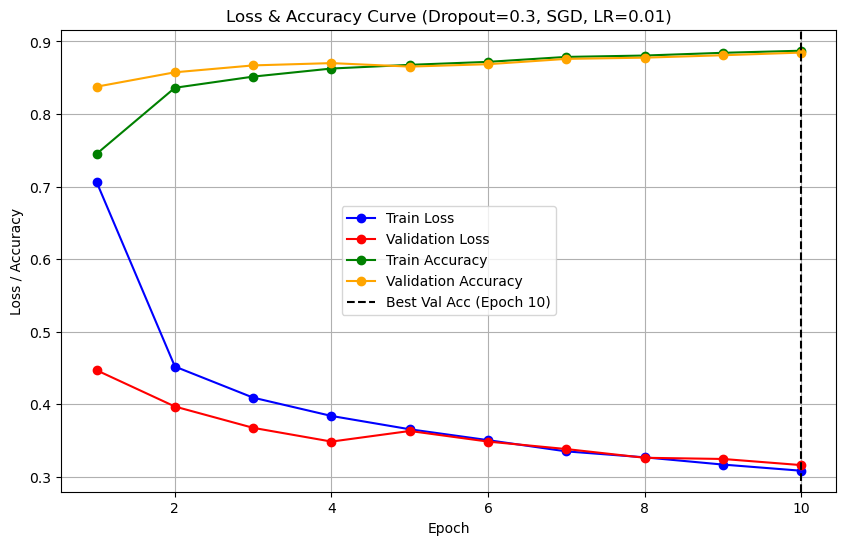

Final Test Accuracy (SGD, LR=0.01, Dropout=0.3): 0.8769

With Dropout=0.5, SGD, LR=0.01, epochs=10
[SGD, LR=0.01, Dropout=0.5] Epoch [1/10] Train Loss: 0.7884, Val Loss: 0.4632, Train Acc: 0.7106, Val Acc: 0.8302
[SGD, LR=0.01, Dropout=0.5] Epoch [2/10] Train Loss: 0.5186, Val Loss: 0.4148, Train Acc: 0.8157, Val Acc: 0.8427
[SGD, LR=0.01, Dropout=0.5] Epoch [3/10] Train Loss: 0.4736, Val Loss: 0.3986, Train Acc: 0.8322, Val Acc: 0.8562
[SGD, LR=0.01, Dropout=0.5] Epoch [4/10] Train Loss: 0.4485, Val Loss: 0.3798, Train Acc: 0.8408, Val Acc: 0.8590
[SGD, LR=0.01, Dropout=0.5] Epoch [5/10] Train Loss: 0.4252, Val Loss: 0.3690, Train Acc: 0.8492, Val Acc: 0.8645
[SGD, LR=0.01, Dropout=0.5] Epoch [6/10] Train Loss: 0.4076, Val Loss: 0.3525, Train Acc: 0.8537, Val Acc: 0.8672
[SGD, LR=0.01, Dropout=0.5] Epoch [7/10] Train Loss: 0.3995, Val Loss: 0.3522, Train Acc: 0.8563, Val Acc: 0.8705
[SGD, LR=0.01, Dropout=0.5] Epoch [8/10] Train Loss: 0.3891, Val Loss: 0.3461, Train Acc: 0.8609, Val A

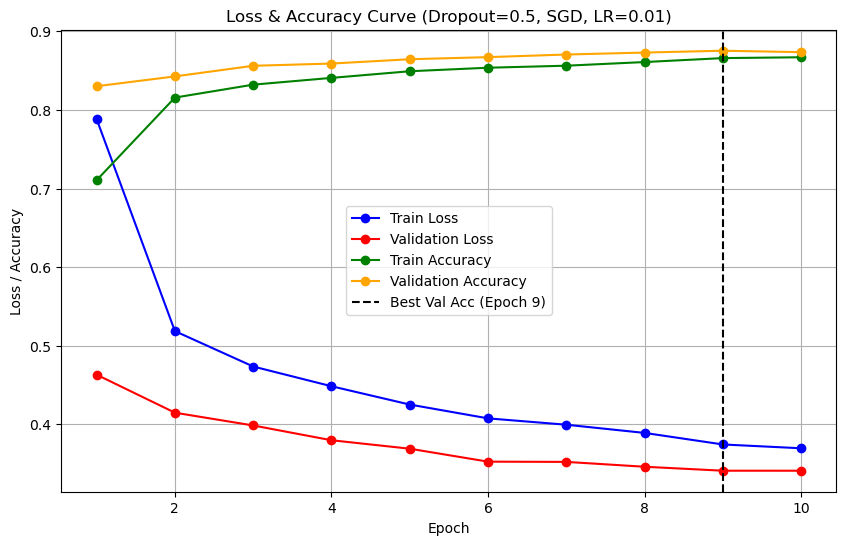

Final Test Accuracy (SGD, LR=0.01, Dropout=0.5): 0.8692


Dropout Comparison Results
NoDropout (Dropout=0.0): Test Acc = 0.8834
Dropout (Dropout=0.3): Test Acc = 0.8769
Dropout (Dropout=0.5): Test Acc = 0.8692


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1) Define an FCN with Dropout
class FCN_Dropout(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[256, 128], dropout_rate=0.3, output_dim=10):
        super(FCN_Dropout, self).__init__()
        layers = []
        all_dims = [input_dim] + hidden_dims + [output_dim]

        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
            if i < len(all_dims) - 2:  # Apply dropout only to hidden layers
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_rate))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.network(x)

# 2) Training & Evaluation Function
def train_and_evaluate_dropout(lr=0.01, dropout_rate=0.3, num_epochs=10):
    # Instantiate model with dropout
    model = FCN_Dropout(input_dim=784, hidden_dims=[256, 128], dropout_rate=dropout_rate, output_dim=10).to(device)

    # Optimizer (Maintains SGD with Momentum from baseline)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Lists to store loss and accuracy values
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_epoch = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_batches:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Compute train loss and accuracy
        train_loss = running_loss / num_train_batches
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_batches:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        # Compute validation loss and accuracy
        val_loss = val_running_loss / num_val_batches
        val_losses.append(val_loss)
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1  

        print(f"[SGD, LR={lr}, Dropout={dropout_rate}] "
              f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_acc:.4f}")

    # Test loop
    test_correct, test_total = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_batches:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total

    # 5) Plot Training & Validation Loss + Accuracy
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(10,6))

    # Loss Curves
    plt.plot(epochs_range, train_losses, 'o-', label='Train Loss', color='blue')
    plt.plot(epochs_range, val_losses, 'o-', label='Validation Loss', color='red')

    # Accuracy Curves
    plt.plot(epochs_range, train_accuracies, 'o-', label='Train Accuracy', color='green')
    plt.plot(epochs_range, val_accuracies, 'o-', label='Validation Accuracy', color='orange')

    # Mark Best Validation Accuracy Epoch
    plt.axvline(x=best_epoch, color='black', linestyle='--', label=f'Best Val Acc (Epoch {best_epoch})')

    plt.title(f'Loss & Accuracy Curve (Dropout={dropout_rate}, SGD, LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Final Test Accuracy (SGD, LR={lr}, Dropout={dropout_rate}): {test_acc:.4f}\n")
    return test_acc

# 3) Compare Models with Different Dropout Rates
dropout_results = {}

# (A) No Dropout (Baseline)
print("No Dropout, SGD, LR=0.01, epochs=10")
dropout_results[('NoDropout', 0.0)] = train_and_evaluate_dropout(
    lr=0.01,
    dropout_rate=0.0,  # No dropout
    num_epochs=10
)

# (B) Dropout = 0.3
print("With Dropout=0.3, SGD, LR=0.01, epochs=10")
dropout_results[('Dropout', 0.3)] = train_and_evaluate_dropout(
    lr=0.01,
    dropout_rate=0.3,
    num_epochs=10
)

# (C) Dropout = 0.5
print("With Dropout=0.5, SGD, LR=0.01, epochs=10")
dropout_results[('Dropout', 0.5)] = train_and_evaluate_dropout(
    lr=0.01,
    dropout_rate=0.5,
    num_epochs=10
)

# 4) Summarize Results
print("\nDropout Comparison Results")
for key, acc in dropout_results.items():
    tag, dr = key
    print(f"{tag} (Dropout={dr}): Test Acc = {acc:.4f}")

# Part 3c

Testing normal initialization
[normal Init, SGD, LR=0.01] Epoch [1/10] Train Loss: 0.9922, Val Loss: 0.5137, Train Acc: 0.6306, Val Acc: 0.8145
[normal Init, SGD, LR=0.01] Epoch [2/10] Train Loss: 0.4602, Val Loss: 0.4401, Train Acc: 0.8330, Val Acc: 0.8402
[normal Init, SGD, LR=0.01] Epoch [3/10] Train Loss: 0.3881, Val Loss: 0.3930, Train Acc: 0.8576, Val Acc: 0.8523
[normal Init, SGD, LR=0.01] Epoch [4/10] Train Loss: 0.3562, Val Loss: 0.3834, Train Acc: 0.8685, Val Acc: 0.8593
[normal Init, SGD, LR=0.01] Epoch [5/10] Train Loss: 0.3293, Val Loss: 0.3433, Train Acc: 0.8798, Val Acc: 0.8748
[normal Init, SGD, LR=0.01] Epoch [6/10] Train Loss: 0.3106, Val Loss: 0.3649, Train Acc: 0.8854, Val Acc: 0.8652
[normal Init, SGD, LR=0.01] Epoch [7/10] Train Loss: 0.2936, Val Loss: 0.3331, Train Acc: 0.8924, Val Acc: 0.8757
[normal Init, SGD, LR=0.01] Epoch [8/10] Train Loss: 0.2814, Val Loss: 0.3239, Train Acc: 0.8957, Val Acc: 0.8755
[normal Init, SGD, LR=0.01] Epoch [9/10] Train Loss: 0.267

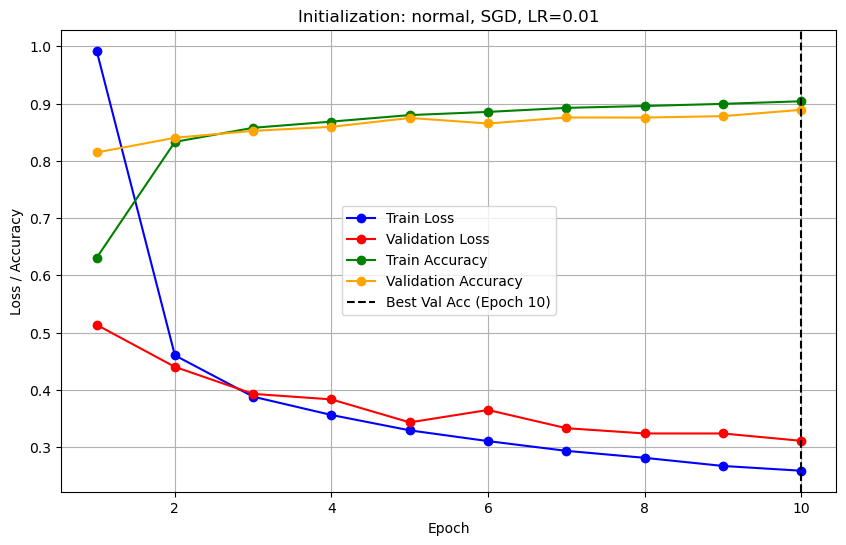

Final Test Accuracy (normal Init, SGD, LR=0.01): 0.8788

Testing xavier_normal initialization
[xavier_normal Init, SGD, LR=0.01] Epoch [1/10] Train Loss: 0.5136, Val Loss: 0.4199, Train Acc: 0.8163, Val Acc: 0.8497
[xavier_normal Init, SGD, LR=0.01] Epoch [2/10] Train Loss: 0.3676, Val Loss: 0.3657, Train Acc: 0.8661, Val Acc: 0.8672
[xavier_normal Init, SGD, LR=0.01] Epoch [3/10] Train Loss: 0.3251, Val Loss: 0.3475, Train Acc: 0.8813, Val Acc: 0.8717
[xavier_normal Init, SGD, LR=0.01] Epoch [4/10] Train Loss: 0.3027, Val Loss: 0.3328, Train Acc: 0.8887, Val Acc: 0.8790
[xavier_normal Init, SGD, LR=0.01] Epoch [5/10] Train Loss: 0.2797, Val Loss: 0.3363, Train Acc: 0.8971, Val Acc: 0.8782
[xavier_normal Init, SGD, LR=0.01] Epoch [6/10] Train Loss: 0.2693, Val Loss: 0.3264, Train Acc: 0.8999, Val Acc: 0.8808
[xavier_normal Init, SGD, LR=0.01] Epoch [7/10] Train Loss: 0.2530, Val Loss: 0.3287, Train Acc: 0.9064, Val Acc: 0.8783
[xavier_normal Init, SGD, LR=0.01] Epoch [8/10] Train Loss:

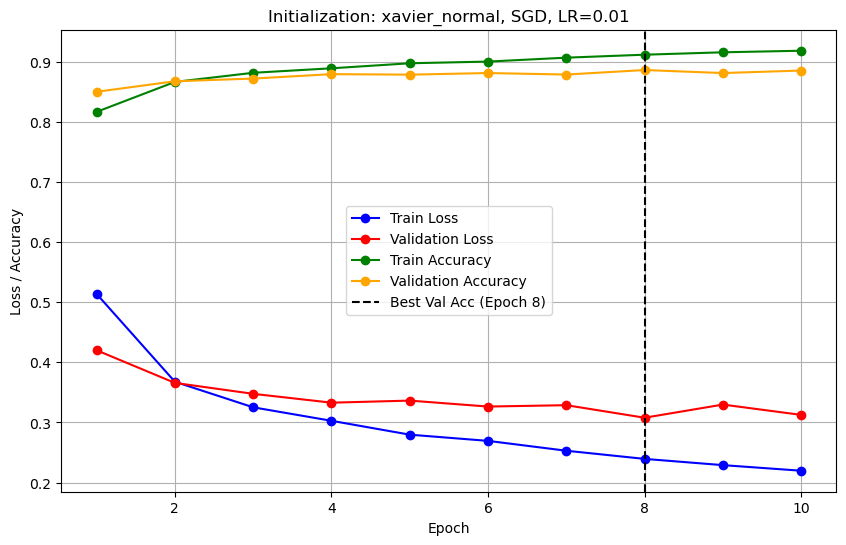

Final Test Accuracy (xavier_normal Init, SGD, LR=0.01): 0.8790

Testing kaiming_uniform initialization
[kaiming_uniform Init, SGD, LR=0.01] Epoch [1/10] Train Loss: 0.5193, Val Loss: 0.4287, Train Acc: 0.8130, Val Acc: 0.8450
[kaiming_uniform Init, SGD, LR=0.01] Epoch [2/10] Train Loss: 0.3670, Val Loss: 0.3695, Train Acc: 0.8658, Val Acc: 0.8678
[kaiming_uniform Init, SGD, LR=0.01] Epoch [3/10] Train Loss: 0.3275, Val Loss: 0.3562, Train Acc: 0.8805, Val Acc: 0.8742
[kaiming_uniform Init, SGD, LR=0.01] Epoch [4/10] Train Loss: 0.3024, Val Loss: 0.3410, Train Acc: 0.8889, Val Acc: 0.8740
[kaiming_uniform Init, SGD, LR=0.01] Epoch [5/10] Train Loss: 0.2838, Val Loss: 0.3268, Train Acc: 0.8953, Val Acc: 0.8778
[kaiming_uniform Init, SGD, LR=0.01] Epoch [6/10] Train Loss: 0.2637, Val Loss: 0.3280, Train Acc: 0.9024, Val Acc: 0.8783
[kaiming_uniform Init, SGD, LR=0.01] Epoch [7/10] Train Loss: 0.2517, Val Loss: 0.3216, Train Acc: 0.9064, Val Acc: 0.8822
[kaiming_uniform Init, SGD, LR=0.01]

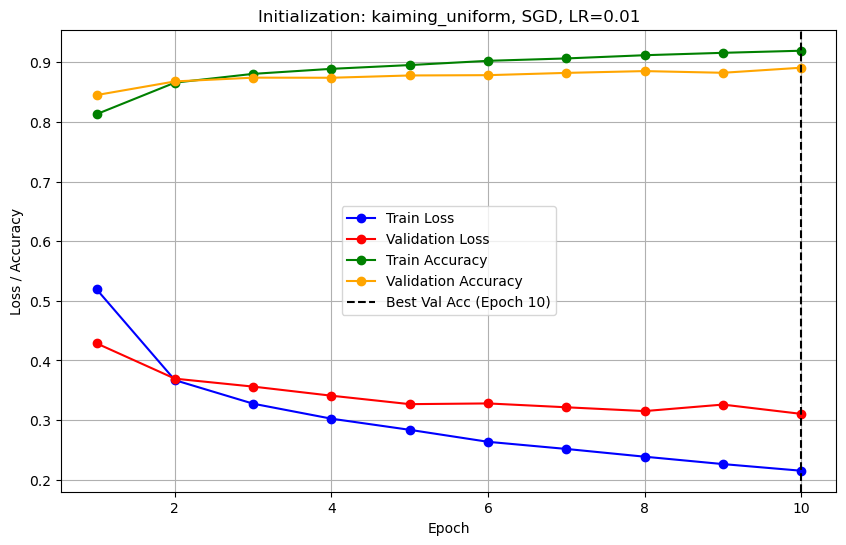

Final Test Accuracy (kaiming_uniform Init, SGD, LR=0.01): 0.8855


Summary of Final Test Accuracies for Different Initialization Methods:
normal Init : Test Accuracy = 0.8788
xavier_normal Init : Test Accuracy = 0.8790
kaiming_uniform Init : Test Accuracy = 0.8855


In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1) Define a helper function for custom weight initialization
def init_weights(module, init_type="xavier_normal"):
    if isinstance(module, nn.Linear):
        if init_type == "normal":
            nn.init.normal_(module.weight, mean=0.0, std=0.01)  # Normal with small std
        elif init_type == "xavier_normal":
            nn.init.xavier_normal_(module.weight)  # Xavier Normal (Glorot)
        elif init_type == "kaiming_uniform":
            nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')  # Kaiming He for ReLU
        else:
            nn.init.normal_(module.weight, mean=0.0, std=0.01)  # Fallback to normal

        if module.bias is not None:
            nn.init.zeros_(module.bias)

# 2) Define an FCN Model
class FCN(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[256, 128], output_dim=10):
        super(FCN, self).__init__()
        layers = []
        all_dims = [input_dim] + hidden_dims + [output_dim]

        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
            if i < len(all_dims) - 2:  # Apply ReLU activation except for last layer
                layers.append(nn.ReLU())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)

# 3) Training and Evaluation Function
def train_and_evaluate(init_type="xavier_normal", lr=0.01, num_epochs=10):
    # Instantiate model and apply weight initialization
    model = FCN(input_dim=784, hidden_dims=[256, 128], output_dim=10).to(device)
    model.apply(lambda m: init_weights(m, init_type=init_type))

    # Optimizer (Maintaining SGD with Momentum from baseline)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Lists to store loss and accuracy values
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_epoch = 0

    # 4) Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_batches:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Compute train loss and accuracy
        train_loss = running_loss / num_train_batches
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # 5) Validation loop
        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_batches:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        # Compute validation loss and accuracy
        val_loss = val_running_loss / num_val_batches
        val_losses.append(val_loss)
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        # Track best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1  # Convert index to epoch number

        print(f"[{init_type} Init, SGD, LR={lr}] "
              f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_acc:.4f}")

    # 6) Test loop
    test_correct, test_total = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_batches:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total

    # 7) Combined Plot: Loss & Accuracy
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 6))

    # Loss Curves
    plt.plot(epochs_range, train_losses, 'o-', label='Train Loss', color='blue')
    plt.plot(epochs_range, val_losses, 'o-', label='Validation Loss', color='red')

    # Accuracy Curves
    plt.plot(epochs_range, train_accuracies, 'o-', label='Train Accuracy', color='green')
    plt.plot(epochs_range, val_accuracies, 'o-', label='Validation Accuracy', color='orange')

    # Mark Best Validation Accuracy
    plt.axvline(x=best_epoch, color='black', linestyle='--', label=f'Best Val Acc (Epoch {best_epoch})')

    plt.title(f'Initialization: {init_type}, SGD, LR={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Final Test Accuracy ({init_type} Init, SGD, LR={lr}): {test_acc:.4f}\n")
    return test_acc

# 4) Initialize with Different Methods and Evaluate Performance
init_methods = ["normal", "xavier_normal", "kaiming_uniform"]
learning_rate = 0.01
num_epochs = 10

init_results = {}

for method in init_methods:
    print(f"Testing {method} initialization")
    final_acc = train_and_evaluate(init_type=method, lr=learning_rate, num_epochs=num_epochs)
    init_results[method] = final_acc  # Store results

# 5) Summarize Results
print("\nSummary of Final Test Accuracies for Different Initialization Methods:")
for method, acc in init_results.items():
    print(f"{method} Init : Test Accuracy = {acc:.4f}")

# Part 3d

Training FCN without BatchNorm (Baseline)
[No BatchNorm, SGD, LR=0.01] Epoch [1/10] Train Loss: 0.6096, Val Loss: 0.4497, Train Acc: 0.7849, Val Acc: 0.8382
[No BatchNorm, SGD, LR=0.01] Epoch [2/10] Train Loss: 0.3934, Val Loss: 0.3804, Train Acc: 0.8566, Val Acc: 0.8595
[No BatchNorm, SGD, LR=0.01] Epoch [3/10] Train Loss: 0.3521, Val Loss: 0.3564, Train Acc: 0.8715, Val Acc: 0.8708
[No BatchNorm, SGD, LR=0.01] Epoch [4/10] Train Loss: 0.3212, Val Loss: 0.3466, Train Acc: 0.8820, Val Acc: 0.8712
[No BatchNorm, SGD, LR=0.01] Epoch [5/10] Train Loss: 0.3030, Val Loss: 0.3425, Train Acc: 0.8894, Val Acc: 0.8708
[No BatchNorm, SGD, LR=0.01] Epoch [6/10] Train Loss: 0.2880, Val Loss: 0.3120, Train Acc: 0.8927, Val Acc: 0.8842
[No BatchNorm, SGD, LR=0.01] Epoch [7/10] Train Loss: 0.2711, Val Loss: 0.3213, Train Acc: 0.8995, Val Acc: 0.8800
[No BatchNorm, SGD, LR=0.01] Epoch [8/10] Train Loss: 0.2607, Val Loss: 0.3059, Train Acc: 0.9036, Val Acc: 0.8873
[No BatchNorm, SGD, LR=0.01] Epoch [9/

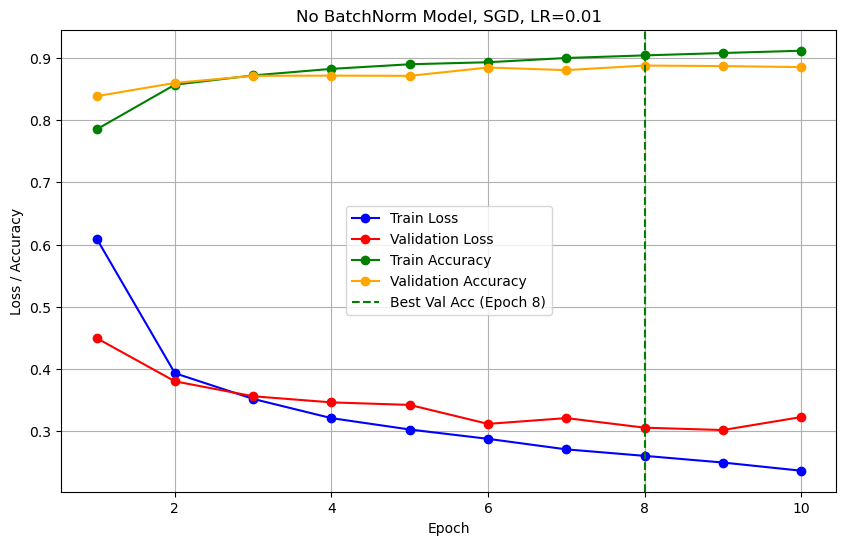

Final Test Accuracy (No BatchNorm Model, SGD, LR=0.01): 0.8748

Training FCN with BatchNorm
[With BatchNorm, SGD, LR=0.01] Epoch [1/10] Train Loss: 0.4865, Val Loss: 0.3871, Train Acc: 0.8314, Val Acc: 0.8603
[With BatchNorm, SGD, LR=0.01] Epoch [2/10] Train Loss: 0.3380, Val Loss: 0.3504, Train Acc: 0.8764, Val Acc: 0.8677
[With BatchNorm, SGD, LR=0.01] Epoch [3/10] Train Loss: 0.3014, Val Loss: 0.3641, Train Acc: 0.8899, Val Acc: 0.8635
[With BatchNorm, SGD, LR=0.01] Epoch [4/10] Train Loss: 0.2761, Val Loss: 0.3393, Train Acc: 0.8984, Val Acc: 0.8758
[With BatchNorm, SGD, LR=0.01] Epoch [5/10] Train Loss: 0.2526, Val Loss: 0.3043, Train Acc: 0.9075, Val Acc: 0.8855
[With BatchNorm, SGD, LR=0.01] Epoch [6/10] Train Loss: 0.2367, Val Loss: 0.3095, Train Acc: 0.9120, Val Acc: 0.8888
[With BatchNorm, SGD, LR=0.01] Epoch [7/10] Train Loss: 0.2218, Val Loss: 0.3255, Train Acc: 0.9179, Val Acc: 0.8855
[With BatchNorm, SGD, LR=0.01] Epoch [8/10] Train Loss: 0.2062, Val Loss: 0.3302, Train A

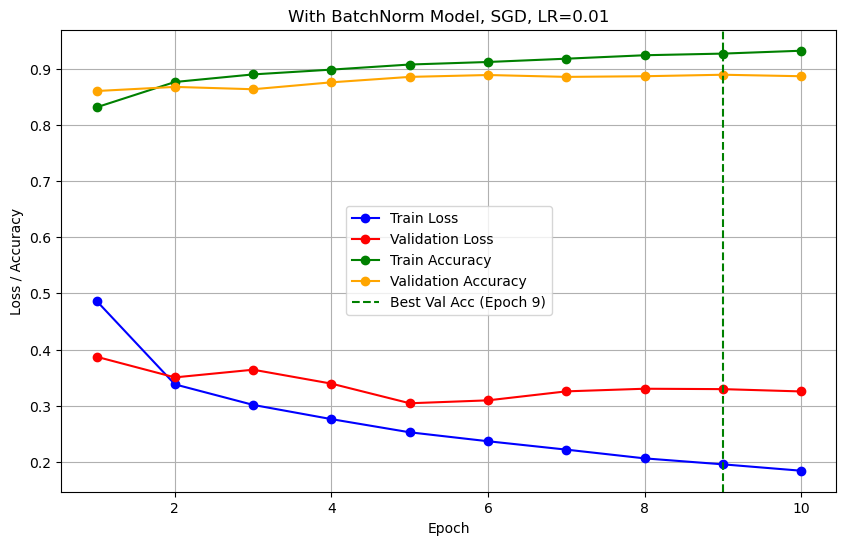

Final Test Accuracy (With BatchNorm Model, SGD, LR=0.01): 0.8775


Summary of Results
No BatchNorm:  Test Acc = 0.8748
With BatchNorm:  Test Acc = 0.8775


In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1) Define FCN model with and without BatchNorm
class FCN(nn.Module):
    """ Fully Connected Network without BatchNorm """
    def __init__(self, input_dim=784, hidden_dims=[256, 128], output_dim=10):
        super(FCN, self).__init__()
        layers = []
        all_dims = [input_dim] + hidden_dims + [output_dim]

        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
            if i < len(all_dims) - 2:  # Apply ReLU to hidden layers
                layers.append(nn.ReLU())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)

class FCN_BN(nn.Module):
    """ Fully Connected Network with BatchNorm """
    def __init__(self, input_dim=784, hidden_dims=[256, 128], output_dim=10):
        super(FCN_BN, self).__init__()
        layers = []
        all_dims = [input_dim] + hidden_dims + [output_dim]

        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
            if i < len(all_dims) - 2:
                layers.append(nn.BatchNorm1d(all_dims[i + 1]))  # Apply BatchNorm
                layers.append(nn.ReLU())

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)

# 2) Training and Evaluation Function
def train_and_evaluate(model, label, lr=0.01, num_epochs=10):
    model = model.to(device)

    # Optimizer (Maintaining SGD with Momentum from baseline)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Lists to store loss and accuracy values
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_epoch = 0

    # 3) Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_batches:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Compute train loss and accuracy
        train_loss = running_loss / num_train_batches
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # 4) Validation loop
        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_batches:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        # Compute validation loss and accuracy
        val_loss = val_running_loss / num_val_batches
        val_losses.append(val_loss)
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        # Track the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1  # Convert index to epoch number

        print(f"[{label}, SGD, LR={lr}] Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_acc:.4f}")

    # 5) Test loop
    test_correct, test_total = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_batches:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    test_acc = test_correct / test_total

    # 6) Combined Plot: Loss & Accuracy
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 6))

    # Loss Curves
    plt.plot(epochs_range, train_losses, 'o-', label='Train Loss', color='blue')
    plt.plot(epochs_range, val_losses, 'o-', label='Validation Loss', color='red')

    # Accuracy Curves
    plt.plot(epochs_range, train_accuracies, 'o-', label='Train Accuracy', color='green')
    plt.plot(epochs_range, val_accuracies, 'o-', label='Validation Accuracy', color='orange')

    # Mark Best Validation Accuracy
    plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Val Acc (Epoch {best_epoch})')

    plt.title(f'{label} Model, SGD, LR={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Final Test Accuracy ({label} Model, SGD, LR={lr}): {test_acc:.4f}\n")
    return test_acc

# 3) Compare Plain FCN vs. FCN_BN with BatchNorm
print("Training FCN without BatchNorm (Baseline)")
model_plain = FCN(input_dim=784, hidden_dims=[256, 128], output_dim=10)
final_acc_plain = train_and_evaluate(model_plain, label="No BatchNorm", lr=0.01, num_epochs=10)

print("Training FCN with BatchNorm")
model_bn = FCN_BN(input_dim=784, hidden_dims=[256, 128], output_dim=10)
final_acc_bn = train_and_evaluate(model_bn, label="With BatchNorm", lr=0.01, num_epochs=10)

# 4) Summary of Results
print("\nSummary of Results")
print(f"No BatchNorm:  Test Acc = {final_acc_plain:.4f}")
print(f"With BatchNorm:  Test Acc = {final_acc_bn:.4f}")

# Part 4

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import struct
import numpy as np
import matplotlib.pyplot as plt

def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class ExtendedFCN(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=[1024, 512, 256], dropout_rate=0.3, output_dim=10):
        super(ExtendedFCN, self).__init__()
        layers = []
        all_dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i+1]))
            # Insert BatchNorm + ReLU + Dropout in hidden layers
            if i < len(all_dims) - 2:
                layers.append(nn.BatchNorm1d(all_dims[i+1]))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout_rate))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        # Flatten from (N, 1, 28, 28) to (N, 784)
        x = x.view(x.size(0), -1)
        return self.network(x)

def train_and_evaluate_improved(model, optimizer_func, lr, num_epochs, train_loader, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optimizer_func(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step()
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = correct / total
    return test_acc

# Part A: FashionMNIST
# Data Loading for FashionMNIST
train_dataset = torchvision.datasets.FashionMNIST(
    'data/', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)
test_dataset = torchvision.datasets.FashionMNIST(
    'data/', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)
train_split = Subset(train_dataset, train_indices)

train_batches = DataLoader(train_split, batch_size=128, shuffle=True)
test_batches  = DataLoader(test_dataset, batch_size=128, shuffle=True)

model_fashion = ExtendedFCN(input_dim=784, hidden_dims=[1024, 512, 256], dropout_rate=0.3, output_dim=10)
model_fashion.apply(init_weights_xavier)
final_acc_fashion = train_and_evaluate_improved(model_fashion, optim.Adam, 0.001, 30, train_batches, test_batches)
print(f"ExtendedFCN Test Accuracy for FashionMNIST = {final_acc_fashion*100:.2f}%")

# Part B: MNIST (via IDX files)
# Load MNIST data
with open('data/train-images.idx3-ubyte', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.uint8)
    X_train_np = data.reshape((size, nrows * ncols))
with open('data/train-labels.idx1-ubyte', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_train_np = np.fromfile(f, dtype=np.uint8)
with open('data/t10k-images.idx3-ubyte', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.uint8)
    X_test_np = data.reshape((size, nrows * ncols))
with open('data/t10k-labels.idx1-ubyte', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_test_np = np.fromfile(f, dtype=np.uint8)

X_train_np = X_train_np.astype(np.float32) / 255.0
X_test_np  = X_test_np.astype(np.float32) / 255.0

X_train_mnist = torch.tensor(X_train_np).view(-1, 1, 28, 28)
y_train_mnist = torch.tensor(y_train_np, dtype=torch.long)
X_test_mnist  = torch.tensor(X_test_np).view(-1, 1, 28, 28)
y_test_mnist  = torch.tensor(y_test_np, dtype=torch.long)

mnist_train_ds = TensorDataset(X_train_mnist, y_train_mnist)
mnist_test_ds  = TensorDataset(X_test_mnist, y_test_mnist)
mnist_train_loader = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
mnist_test_loader  = DataLoader(mnist_test_ds, batch_size=128, shuffle=False)

model_mnist = ExtendedFCN(input_dim=784, hidden_dims=[1024, 512, 256], dropout_rate=0.3, output_dim=10)
model_mnist.apply(init_weights_xavier)
final_acc_mnist = train_and_evaluate_improved(model_mnist, optim.Adam, 0.001, 30, mnist_train_loader, mnist_test_loader)
print(f"ExtendedFCN Test Accuracy for MNIST = {final_acc_mnist*100:.2f}%")

ExtendedFCN Test Accuracy for FashionMNIST = 90.21%
ExtendedFCN Test Accuracy for MNIST = 98.86%


In [176]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Extract training and test data from the datasets
X_train = train_dataset.data.view(-1, 28*28).float().numpy()
y_train = train_dataset.targets.numpy()
X_test  = test_dataset.data.view(-1, 28*28).float().numpy()
y_test  = test_dataset.targets.numpy()

# Initialize and train the KNN classifier with k=3
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Predict and compute test accuracy for KNN
y_pred = knn_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Test Accuracy = {knn_accuracy * 100:.2f}%")

KNN Test Accuracy = 85.41%
